In [2]:
import csv
import pandas as pd
# from pandas import Timestamp
from time import mktime, strftime, strptime
from datetime import datetime
from tqdm.auto import tqdm, trange

c:\Users\eeb02\.virtualenvs\HW2-PfLazmZH\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. 挑選股票紀錄


- 先讀入指定標籤中(上市櫃、年分)的紀錄，以及指定的欄位資訊

In [37]:
# 讀取股市資料
pick_cols = ['證券代碼','年月日','收盤價(元)','成交量(千股)']
market_raw = pd.read_excel('./bda2023_mid_dataset/stock_data_2019-2023.xlsx', \
    sheet_name=['上市2019', '上市2020', '上市2021', '上市2022', '上市2023'], usecols=pick_cols)
market_raw['上市2023'].head()

,證券代碼,年月日,收盤價(元),成交量(千股)
0,0050 元大台灣50,2023/03/24,122.20,13919
1,0051 元大中型100,2023/03/24,57.40,41
2,0052 富邦科技,2023/03/24,110.10,383
3,0053 元大電子,2023/03/24,61.30,5
4,0055 元大MSCI金融,2023/03/24,21.83,220


- 從中挑出指定的股票代碼，本次實驗挑選的是 "2603 長榮"
- 因為讀取全部股票紀錄較花時間。挑出後，存成檔案做為紀錄點，方便後續使用

In [38]:
# 取出指定代碼股票紀錄
# ticks = ['2603 長榮','2609 陽明', '2610 華航', '2618 長榮航', '0050 元大台灣50']
ticks = ['2603 長榮']

# 整理出存檔路徑
f_path = []
for i in range(len(ticks)):
    path_str = ticks[i]
    f_path.append(f'./ticks_data/{path_str[0:4]}_19-23.csv')

# 篩選
for i in range(len(ticks)):   
    tmp_df = pd.DataFrame()  
    for market_year in market_raw:
        tmp = market_raw[market_year].loc[market_raw[market_year]['證券代碼'] == ticks[i], :]
        tmp = tmp.iloc[::-1]
        tmp_df = pd.concat([tmp_df, tmp], ignore_index=True)
        
    # Write save points to file
    # 繁中字編碼可改 'utf-8' or 'big5'
    tmp_df.to_csv(f_path[i], encoding='big5', index=False)
    
# head = tmp_df.columns  # 取出欄位定義
# print(len(tmp_df.index)) 
# tmp_df.head()

- 從檔案中讀取指定代碼的紀錄

In [3]:
ticks = ['2603 長榮']
market_data = {}

# 讀檔
for tick in ticks:
    market_data[tick] = pd.read_csv(f'./ticks_data/{tick[0:4]}_19-23.csv', delimiter=',', encoding='big5',index_col=False)
    # 從csv檔讀出時，時間格式會變成windows樣式，要再把格式轉回datetime
    market_data[tick]['年月日'] = market_data[tick]['年月日'].apply( \
        lambda x: datetime.fromtimestamp(mktime(strptime(x, '%Y/%m/%d'))))
    
print(type(market_data[tick]['年月日'][0]))
head = market_data[ticks[0]].columns
print(head)
market_data[ticks[0]].head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Index(['證券代碼', '年月日', '收盤價(元)', '成交量(千股)'], dtype='object')


,證券代碼,年月日,收盤價(元),成交量(千股)
0,2603 長榮,2019-01-02,11.7884,5111
1,2603 長榮,2019-01-03,11.7389,5048
2,2603 長榮,2019-01-04,11.4912,12347
3,2603 長榮,2019-01-07,11.8380,7842
4,2603 長榮,2019-01-08,11.7389,4366


# 2.篩選文章和標註(Labeling)

## 標註
- 定義labeling method: 我們選擇不標"漲"或"跌"。而是將漲跌%數作為標記，不做分類而是迴歸。
- rol_window 控制要計算幾天間的價差
- 回傳的標註可為dict { date: label } 或dataframe型別

In [102]:
# Mark labels
def markLabels(data=pd.DataFrame, n_date: int=1, ret_type: str='dict') -> pd.DataFrame | dict:
    # return as Dataframe
    if ret_type == 'df':
        tmp = list()
        for i in data.index:
            if i<(len(data.index) - n_date):
                period_chg = data['收盤價(元)'][i+n_date]-data['收盤價(元)'][i]
                period_pct = (period_chg/(data['收盤價(元)'][i]+0.000001))*100.0            
                tmp.append(round(period_pct, 0))
                
        tmp.extend([0.0]*n_date)    
        data['Label'] = tmp  
        return data

    # return as dict
    else:
        labels = {}
        for i in data.index:
            if i<(len(data.index) - n_date):
                period_chg = data['收盤價(元)'][i+n_date]-data['收盤價(元)'][i]
                period_pct = (period_chg/(data['收盤價(元)'][i]+0.000001))*100.0
                # dt = datetime.fromtimestamp(mktime(strptime(data['年月日'][i], '%Y/%m/%d')))  # 上面已轉換
                k = datetime.strftime(data['年月日'][i], '%Y-%m-%d')
                labels[data['年月日'][i]] = round(period_pct, 3)
        print(type(data['年月日'][i]))
        return labels 
# test = markLabels(data_2603, 3)
# data_2603.loc[data_2603['Label']>10, :]
# data_2603.loc[data_2603['Label']>0, ['年月日']]

- 將資料和標註合併的method，同時能設定條件，篩出指定的label

In [73]:
def matchDataLabel(data: list|pd.DataFrame, labels: dict|list) -> dict:
    tmp = sorted(set(data))
    ret_labels = dict()
    for time in tmp:
        # time = datetime.strftime(time, '%Y-%m-%d')
        if time in labels:
        # if time in labels and labels[time] >= 5.0:  # 設定條件
            ret_labels[time] = labels[time]
    return ret_labels

- 標註主程式，extracted_time是key為date、value為label的dict

In [265]:
labels = markLabels(market_data[ticks[0]], n_date=3)
extracted_time = matchDataLabel(market_data[tick]['年月日'], labels)    

print(f'Feature length: {len(extracted_time.keys())}')
# extracted_time
# print(extracted_time)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
Feature length: 1023


- 計算漲和跌的分布，後面評估用

In [104]:
truth_list = []
for m in range(39):
    start = pd.Timestamp(year=2020, month=1, day=1)+ pd.DateOffset(months=m)
    end = start + pd.DateOffset(months=1, days=-1)
    up = 0
    down = 0
    for d in extracted_time.keys():
        if d >= start and d <= end:
            if extracted_time[d] > 0:
                up+=1
            elif extracted_time[d] < 0:
                down+=1
    
    truth_list.append([up, down])
print(truth_list[0:5])

[[4, 10], [7, 10], [7, 15], [13, 7], [12, 7]]


## 讀取文章

- 設定讀檔路徑

In [10]:
# file path
file_paths = [
    'bda2023_mid_bbs_2019-2021.csv',
    'bda2023_mid_bbs_2022-2023.csv',
    'bda2023_mid_forum_2020.csv',
    'bda2023_mid_forum_2021.csv',
    'bda2023_mid_forum_2022-2023.csv',   
    # 'bda2023_mid_news_2020.csv',
    # 'bda2023_mid_news_2021.csv',
    # 'bda2023_mid_news_2022.csv',
    # 'bda2023_mid_news_2023.csv',
    # 'bda2023_mid_news_2022-2023.csv', 
]

news_paths = [
    'bda2023_mid_news_2020.csv',
    'bda2023_mid_news_2021.csv',
    'bda2023_mid_news_2022.csv',
    'bda2023_mid_news_2023.csv',
    'bda2023_mid_news_2022-2023.csv',
]

- 讀取文章至dataframe

In [11]:
# Read file
articles_df = pd.DataFrame()
for file in tqdm(news_paths):
    tmp_df = pd.read_csv('./bda2023_mid_dataset/'+file, delimiter=',', encoding='utf-8',
                       usecols=['post_time', 'title', 'content'])
    articles_df = pd.concat([articles_df, tmp_df], ignore_index=True)
print(f'num of articles: {len(articles_df.index)}')
articles_df.head()

100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

num of articles: 925791


,post_time,title,content
0,2020-01-01 00:28:00,財政部、內政部推一站式服務 不動產移轉登記一次搞定,為避免民眾辦理不動產買賣移轉登記，需要稅務、地政機關兩邊跑，財政部與內政部合作成立「不動產移...
1,2020-01-01 00:29:00,IMF：Q3美元佔全球外匯儲備比重升至一年新高,週二 (31 日) 國際貨幣組織公布 (IMF) 數據顯示，今年第 3 季，美元在全球外匯儲...
2,2020-01-01 01:15:00,騰訊集團以34億美元 收購環球音樂10%股權,外電報導，騰訊集團 (0700-HK) 與法國多媒體集團威望迪 (Vivendi)，在經過了...
3,2020-01-01 03:23:00,加幣漲幅勇冠G10 瑞信：央行政策是明年主要風險,週二 (31 日)，受到中國強勁經濟數據支持，加元兌美元匯率升至 14 個月高位，且年度漲幅...
4,2020-01-01 03:41:00,【歐股盤後】收低,（中央社台北2020年1月1日電）歐洲股市在今年最後一個交易日交易清淡，倫敦和巴黎股市收低，...


- 統一時間格式，可為pd.Timestamp或Datetime.datetime

In [12]:
# 轉換時間格式
articles_df['post_time'] = pd.to_datetime(articles_df['post_time']).dt.normalize() # 將時間統一到 00:00:00
# articles_df['post_time'] = articles_df['post_time'].dt.floor('D')

# 上面methods執行會比下面快
# articles_df['post_time'] = pd.to_datetime(articles_df['post_time']).dt.date
print(articles_df['post_time'][5130])
# 測試取出日期屬性  index 5130 = 2019-03-30
articles_df['post_time'][5130].month

2020-01-08 00:00:00


1

- 將標記移置train_df上

In [13]:
train_df = articles_df.copy()
train_df['label'] = train_df['post_time'].apply(lambda x: extracted_time.get(x, None))
# train_df['label'] = train_df['post_time'].apply(lambda x: extracted_time.get(datetime.strftime(x, '%Y-%m-%d')))

- 根據標註挑選

In [14]:
train_df = train_df.loc[train_df['label'] >= 5.0, :]
train_df = train_df.reset_index(drop=True)
# [22050] = '2020-01-30'
# train_df['label'][22050]
# ans = lambda x: extracted_time.get(datetime.strftime(x, '%Y-%m-%d'), None)
# ans(train_df['post_time'][22050])
print(len(train_df['label']))
train_df.tail(5)

173888


,post_time,title,content,label
173883,2023-03-08,【公告】大億董事會通過關係人捐贈案,日 期：2023年03月08日公司名稱：大億 (1521)主 旨：大億董事會通過關係人捐贈案...,6.0
173884,2023-03-08,2月筆電出貨微幅回溫 緯創Q1營收逐月升,緯創（3231）2月筆電出貨微幅回溫、達120萬台，帶動月營收亦月增逾一成、達620.67億...,6.0
173885,2023-03-08,通膨問題緩解 拜登支持度升至42％,路透／益普索（Ipsos）最新調查顯示，美國總統拜登的民意支持度如今升至42％，創下去年6月...,6.0
173886,2023-03-08,歐元區去年第四季GDP零成長 不影響ECB升息腳步,歐盟統計局8日公布，歐元區去年第四季國內生產毛額（GDP）終值由上次預估的季增0.1％下修至...,6.0
173887,2023-03-08,鮑爾放鷹 美債驚見1981年來最嚴重倒掛,聯準會（Fed）主席鮑爾7日赴國會作證時高唱鷹調，刺激美國2年期公債殖利率飆破5％，創下20...,6.0


## 斷詞

- 引入斷詞工具monpa所需套件

In [15]:
import monpa
from monpa import utils
import torch
from collections import Counter

+---------------------------------------------------------------------+
  Welcome to MONPA: Multi-Objective NER POS Annotator for Chinese
+---------------------------------------------------------------------+
已找到 model檔。Found model file.


- 確認GPU狀態

In [16]:
if torch.cuda.is_available():
    monpa.use_gpu(True)

def print_gpu_memory():
    gpu_state = torch.cuda.is_available()
    total_m = torch.cuda.get_device_properties(0).total_memory/(1024**2)
    reserved_m = torch.cuda.memory_reserved(0)/(1024**2)
    allocated_m = torch.cuda.memory_allocated(0)/(1024**2)
    free_m = reserved_m-allocated_m
    
    print('GPU state: {:s}\nGPU total memory: {:.2f} MB\nReserve for excution: {:.2f} MB\nExecution allocated: {:.2f} MB\nFree memory: {:.2f} MB'\
        .format('Available' if gpu_state else 'None', total_m, reserved_m, allocated_m, free_m))

print_gpu_memory()

GPU state: Available
GPU total memory: 11263.75 MB
Reserve for excution: 0.00 MB
Execution allocated: 0.00 MB
Free memory: 0.00 MB


- 將標題和內容合併

In [17]:
# Combine 'title' & 'content'
def combine_str(series):
    tmp_str = ''
    try:
        tmp_str = series['title']+'。'+series['content']
    except:
        tmp_str = str(series['title'])+'。'+str(series['content'])
    
    return tmp_str    
    
train_df['combined'] = train_df.apply(combine_str, axis=1)

- 定義斷詞method

In [18]:
def word_Tokenize(contents: pd.DataFrame, forW2V: bool=False):
    err_data = list()
    tf_counter = Counter()
    df_counter = Counter()
    total = len(contents.index)
    
    if forW2V:
        W2V = list()
    
    for i in tqdm(contents.index, desc="Cutting process: "):
        total -= 1
        if  total % 5000 == 0:
            print_gpu_memory()
            # Clear gpu cache
            # torch.cuda.empty_cache()           
                
        df_tmp = Counter()
        sentence_list = utils.short_sentence(contents['combined'][i])
        result_cut = monpa.cut_batch(sentence_list) #斷詞 GPU加速method
        
        # print(result_cut)
        tmp_row = list()
        for terms in result_cut:            
            if len(terms) > 0: 
                term = terms[0].strip() #去除前後多餘空白
                # print(term)
                #若詞長>1 (排除標點符號、單字)，排除英數字
                if(len(term)>1 and len(term)<=8) \
                    and (not term.isdigit()): 
                    # print(type(term))
                    tf_counter[term]+=1 #tf加1
                    if(df_tmp[term]==0): #若本篇之前不曾出現
                        df_tmp[term]=1 #df標為1
                    tmp_row.append(term)
                    
        if forW2V:
            W2V.append(tmp_row)
        
        df_counter+=df_tmp # 累加多篇df        
    
    if forW2V:
        f = open('./mid-term/Word2Vec/raw.csv', 'w', newline='', encoding='utf-8')
        writer = csv.writer(f, delimiter=',')
        for items in W2V:
            writer.writerow(items)
        f.close()
        
    return tf_counter, df_counter, err_data    

- 斷詞主程式

In [19]:
result = []

# Cutting main proc
print_gpu_memory()
# tf, df, err = word_Tokenize(train_df, False)
# print(f'tf counter result: \n{tf.most_common(100)}.')
# print(f'df counter result: \n{df.most_common(100)}.')
# print(f'Error avoid {len(err)} times.')

GPU state: Available
GPU total memory: 11263.75 MB
Reserve for excution: 0.00 MB
Execution allocated: 0.00 MB
Free memory: 0.00 MB


## 外部引入已斷詞資料

- 讀取檔案

In [263]:
token_OK = pd.read_csv('./terms_data/mid_bbs_OK.csv', delimiter=',', encoding='utf-8')
token_OK.tail()

,post_time,content
139091,2023-03-21,情報 21 市場 虧損 最多 股票 21 市場 虧損 股票 創意 999.8 華孚 688...
139092,2023-03-21,新聞 葉倫 提振 市場 信心 美股 道瓊 早盤 原文 標題 葉倫 提振 市場 信心 美股 ...
139093,2023-03-21,新聞 社子 三萬 預警 停電 王美花 道歉 原文 標題 社子 三萬 預警 停電 王美花 道...
139094,2023-03-21,新聞 聯電 新加坡 擴廠 亞翔 82.59 大單 原文标题 聯電 新加坡 擴廠 亞翔 82...
139095,2023-03-21,新聞 郭哲榮 大絕招 出現 不會 原文 標題 郭哲榮 大絕招 出現 不會 金融 風暴 原文...


- 調整時間格式，併入標註

In [241]:
token_OK['post_time'] = pd.to_datetime(token_OK['post_time']).dt.normalize()
token_OK['label'] = token_OK['post_time'].apply(lambda x: extracted_time.get(x, None))
token_OK = token_OK.loc[token_OK['label'].notna(), :].reset_index(drop=True)
print(len(token_OK['label']))
token_OK.tail()

352092


,post_time,content,label
352087,2023-03-21,友達 ❷❺ 元以 蘇起 不知 多少 老是 說話,0.0
352088,2023-03-21,長期 投資人 ETF 超額 報酬 建議 巴菲特 2013年 股東信 提出 建議 一般人 不...,0.0
352089,2023-03-21,美國 台積電 美國 設廠 不會 影響 美國 台灣 安全 承諾 晶片 中國 打掉 台灣 之後...,0.0
352090,2023-03-21,快笑死 根本 指標 AI 股票 AI 解說 股市 重大 事件 矽谷銀行 倒閉,0.0
352091,2023-03-21,AI 股票 AI 解說 股市 重大 事件 矽谷銀行 倒閉 預測 短期 一日 行情 甚麼 意...,0.0


# 3. 文章向量化模型

In [242]:
from gensim.models import word2vec, Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import csv
import numpy as np
from scipy.spatial.distance import cosine

- 引入已訓練完成的模型

In [244]:
vector_size = 250  # 定義向量維度
# vectorize_model = Word2Vec.load('./Word2Vec/models/w2v_x250.model')
vectorize_model = Doc2Vec.load('./Word2Vec/D2V_models/d2v_x250.model')

- 相關methods

In [ ]:
# vectorize_model.wv.most_similar('晶片', topn=20)
# vectorize_model.wv.get_vector('輝達')
# similarity = cosine(BVector, UPdocVector)

- 文章向量method
- for Word2Vec model


In [ ]:
# Word2Vec
def getDocVec_w2v(model, docterms: list, vec_size: int=250):
    docVec = np.zeros(vec_size)
    for term in docterms:
        try:
            docVec += model.wv.get_vector(term)
        except:
            continue
    return docVec/len(docterms)

- for Doc2Vec model
- alpha是步長，steps迭代步數

In [ ]:
# Doc2Vec
def getDocVec_d2v(model, docterms: list, vec_size: int=250):
    # docVec = np.zeros(vec_size)
    # print(docterms)
    docVec = model.infer_vector(doc_words=docterms, alpha=0.003, epochs=500)    
    return docVec


- 轉換為list of str method

In [ ]:
def str2list(input: pd.Series, print_info:bool):
    input = input.apply( lambda x: x.split() )
    input.apply( lambda x: x.pop(0) )
    if print_info:
        print(input.head())

## 迴歸分析模型

- 選用XGBoosting Regressor
- tree_method = 'gpu_hist'，啟用GPU加速

In [ ]:
import xgboost as xgb
regressor = xgb.XGBRegressor(n_estimators=250, max_depth=8, tree_method = 'gpu_hist', gpu_id=0, learning_rate=0.75, booster='gbtree', predictor='gpu_predictor')

In [ ]:
# regressor.fit(data, labels)
# pred = regressor.predict()
# regressor.score(x, y)

# 4. 訓練集文章

- 篩選，設定label條件

In [ ]:
feature_df = token_OK.copy()
feature_df = feature_df.loc[abs(feature_df['label']) >= 2.0, :]  # 設定label條件
feature_df = feature_df.reset_index(drop=True)
print(len(feature_df['label']))
feature_df.tail(5)

430352


,post_time,content,label
430347,2023-03-20,舜宇光學 去年 盈利腰斬 降至 人民幣 24億 港股 上市 手機 設備 製造商 舜宇光學 ...,-2.0
430348,2023-03-20,印月 周年慶 消費 桌菜 客套餐 招牌 烤鴨 半價 優惠 藝術 烤鴨 饗宴 台中 餐飲 市...,-2.0
430349,2023-03-20,UN 研究 索馬利亞 旱災 造成 135 死亡 索馬利亞衛生部 世界衛生組織 WHO 聯合...,-2.0
430350,2023-03-20,金融業 危機 升息 可能 暫緩 美股 開盤 漲跌 中央社 紐約 2023年 3月 20日 ...,-2.0
430351,2023-03-20,"看準 普發 6000 現金 商機 台中 福華 客房 全民 普發 6,000 現金 終於 隨...",-2.0


- 設定 2021 5-7月為訓練集

In [ ]:
train_start = pd.Timestamp(year=2020, month=5, day=1)
train_end = train_start + pd.DateOffset(months=3, days=-1)
print("Training period: ", train_start, ", Ends on: ", train_end)

Training period:  2020-05-01 00:00:00 , Ends on:  2020-07-31 00:00:00


In [ ]:
train_df = feature_df[feature_df['post_time'].between(train_start, train_end)]
train_df = train_df.reset_index(drop=True)
train_df.tail()

,post_time,content,label,DocVec
19493,2020-07-28,弊案 貪污 洗錢罪 12 納吉 滿意 上訴 馬來西亞 相納吉 Najib Razak 今天...,3.0,"[-0.00036011075, -0.0018687549, 0.0019195958, ..."
19494,2020-07-28,Fed 多數 緊急 貸款 計劃 期限 延至 今年 美國 聯準會 Fed 週二 28 日 宣...,3.0,"[0.0015795567, -0.0012143344, -0.0011098108, 8..."
19495,2020-07-28,武漢 肺炎 疫情 衝擊 麥當勞 營收 衰退 30 中央社 芝加哥 2020年 7月 28日...,3.0,"[3.792453e-05, 0.0013142963, 0.0014178028, 0.0..."
19496,2020-07-28,A7S III Sony 影片 拍攝 準備 利器 官方 所有 一切 Sony 新機 A7S...,3.0,"[-8.2428574e-05, 4.1431427e-05, -0.0012430022,..."
19497,2020-07-28,代工 做到 台積電 客製化 需求 258 製程 中央社 記者 蘇思 台北 2020年 7月...,3.0,"[0.0006782772, -0.00014913022, 0.0014591606, -..."


- 將Content轉為list of str

In [ ]:
str2list(train_df['content'], True)

0    [新增, 1萬102, 染疫, 單日, 確診, 破萬, 路透莫斯科, 俄羅斯, 疫情危機應變...
1    [去年, 12月, 爆發, 疫情, 世衛, 意外, 路透日內瓦, 世界衛生組織, WHO, ...
2    [2019年, 病例, 專家, 疫情, 評估, 重要, 路透倫敦, 專家, 今天, 指出, ...
3    [14兆, 美元, 美國, 第一, 家庭, 債務, 水平, 新高, 紐約聯邦銀行, New,...
4    [Ameritrade, 疫情, 重創, 航空業, 散戶, 投資, 航空股, 儘管, 新冠,...
Name: content, dtype: object


- 獲得文章向量

In [ ]:
train_df['DocVec'] = train_df['content'].apply( lambda x: getDocVec_d2v(vectorize_model, [x]) )
train_df.tail()

,post_time,content,label,DocVec
19493,2020-07-28,弊案 貪污 洗錢罪 12 納吉 滿意 上訴 馬來西亞 相納吉 Najib Razak 今天...,3.0,"[-0.00036011075, -0.0018687549, 0.0019195958, ..."
19494,2020-07-28,Fed 多數 緊急 貸款 計劃 期限 延至 今年 美國 聯準會 Fed 週二 28 日 宣...,3.0,"[0.0015795567, -0.0012143344, -0.0011098108, 8..."
19495,2020-07-28,武漢 肺炎 疫情 衝擊 麥當勞 營收 衰退 30 中央社 芝加哥 2020年 7月 28日...,3.0,"[3.792453e-05, 0.0013142963, 0.0014178028, 0.0..."
19496,2020-07-28,A7S III Sony 影片 拍攝 準備 利器 官方 所有 一切 Sony 新機 A7S...,3.0,"[-8.2428574e-05, 4.1431427e-05, -0.0012430022,..."
19497,2020-07-28,代工 做到 台積電 客製化 需求 258 製程 中央社 記者 蘇思 台北 2020年 7月...,3.0,"[0.0006782772, -0.00014913022, 0.0014591606, -..."


# 5. 測試集文章

- 設定2021 8月為測試集

In [ ]:
test_start = train_end + pd.DateOffset(days=1)
test_end = test_start + pd.DateOffset(months=1, days=-1)
print("Testing period: ", test_start, " To ", test_end)

Testing period:  2020-08-01 00:00:00  To  2020-08-31 00:00:00


- 要注意測試集挑選的母體和訓練集不同，訓練集有根據Label條件篩選，而測試集則無
- 選用token_ok而非feature_df

In [ ]:
test_df = token_OK[token_OK['post_time'].between(test_start, test_end)]
test_df = test_df.reset_index(drop=True)
test_df.tail()

,post_time,content,label,DocVec
9130,2020-08-31,公告 宣德 董事會 決議 修訂 109年度 員工 股權 憑證 發行 辦法 2020年 08...,5.0,"[-0.001198469, -0.0015033965, -0.0009969192, 0..."
9131,2020-08-31,公告 桃禧 109年 07 月份 自結 財務 報告 負債 比率 流動 比率 速動 比率 2...,5.0,"[-8.5244894e-05, -0.00015519095, -0.001024982,..."
9132,2020-08-31,經濟部 製造業 技術 服務業 紓困 開放 申請 經濟部 公告 受理 紓困 3.0 申請 開...,5.0,"[-0.00091107417, 0.0003317206, 0.0017385588, -..."
9133,2020-08-31,豪雨 釀災 印度尼泊爾 過去 至少 41 路透 尼泊爾加德 滿都 印度 阿默達巴德 31 ...,5.0,"[-0.0018256475, -0.0001462642, -0.0015029322, ..."
9134,2020-08-31,TikTok 出售案 9月 1日 宣布 得標 週一 31 日 外媒 引述 消息 人士 說法...,5.0,"[0.0014001117, 0.00093561603, 0.001481647, -0...."


- 將content轉為list of str

In [ ]:
str2list(test_df['content'], True)

0    [貿易, 顧問, 微軟, TikTok, 可能, 中國, 撤資, 路透華盛頓, 傳聞, 美國...
1    [推手, 修姆, 辭世, 前英相布萊爾, 讚揚, 貢獻, 卓越, 路透倫敦, 北愛爾蘭和平,...
2    [iPhone, SE, Google, 殺手級, 新機, Pixel, 4a, 問世, 價...
3    [上揚, 中央社, 台北, 2020年, 8月, 4日, 歐股, 上揚, 原因, 經濟, 數...
4    [建議, 微軟, 買下, TikTok, 公司, 美政府, 微軟, 週日, 證實, TikT...
Name: content, dtype: object


- 取得測試集文章向量

In [ ]:
test_df['DocVec'] = test_df['content'].apply( lambda x: getDocVec_d2v(vectorize_model, x) )
test_df['DocVec'].head()

0    [-0.13461189286415176, -0.030154600847899365, ...
1    [-0.2429211176092356, -0.10827881329181328, -0...
2    [0.009816042236427123, 0.13853685692006312, -0...
3    [-0.18188376461934538, -0.020597239553231245, ...
4    [-0.25123012696054675, 0.025732903348398395, -...
Name: DocVec, dtype: object

In [ ]:
test_df['DocVec'][0].shape

(250,)

# 6. 訓練模型

- 將型別轉為float

In [ ]:
train_f = list()
for item in train_df['DocVec']:
    train_f.append(item.astype(float))
# print(train_f[-1])

In [ ]:
len(train_f[0])

250

- Training

In [ ]:
regressor.fit(train_f, train_df['label'])
print("Traing Score: ", regressor.score(train_f, train_df['label']))

Traing Score:  0.9981248116402084


- Testing

In [ ]:
test_f = list()
for item in test_df['DocVec']:
    test_f.append(item.astype(float))

# regressor.set_param({'predictor': 'gpu_predictor'})
test_df['pred_label'] = regressor.predict(test_f)
test_df.tail()

,post_time,content,label,DocVec,pred_label
9130,2020-08-31,公告 宣德 董事會 決議 修訂 109年度 員工 股權 憑證 發行 辦法 2020年 08...,5.0,"[-0.001198469, -0.0015033965, -0.0009969192, 0...",-1.946403
9131,2020-08-31,公告 桃禧 109年 07 月份 自結 財務 報告 負債 比率 流動 比率 速動 比率 2...,5.0,"[-8.5244894e-05, -0.00015519095, -0.001024982,...",-2.183610
9132,2020-08-31,經濟部 製造業 技術 服務業 紓困 開放 申請 經濟部 公告 受理 紓困 3.0 申請 開...,5.0,"[-0.00091107417, 0.0003317206, 0.0017385588, -...",1.121093
9133,2020-08-31,豪雨 釀災 印度尼泊爾 過去 至少 41 路透 尼泊爾加德 滿都 印度 阿默達巴德 31 ...,5.0,"[-0.0018256475, -0.0001462642, -0.0015029322, ...",-0.081396
9134,2020-08-31,TikTok 出售案 9月 1日 宣布 得標 週一 31 日 外媒 引述 消息 人士 說法...,5.0,"[0.0014001117, 0.00093561603, 0.001481647, -0....",-1.158781


- 評估準確率
- 將同天的predicts平均後，絕對值大於threshold就出手
- 出手後，再看是否和label的漲跌相符


In [ ]:
go_up, go_down, miss_up, miss_down = 0, 0, 0, 0
res_df = test_df.groupby('post_time')['pred_label'].mean()
for d in res_df.index:
    if abs(res_df[d]) > 0:  # 設定判斷邊際
        gt = extracted_time[pd.Timestamp(d)]
        if res_df[d] > 0 and gt > 0:
            go_up += 1
        elif res_df[d] > 0 and gt < 0:
            miss_up += 1          
        elif res_df[d] < 0 and gt < 0:
            go_down += 1
        else:
            miss_down += 1
    
print("Action percentage: {:.2f}%".format((go_up+go_down+miss_up+miss_down)*100/(truth_list[7][0]+truth_list[7][1])))
print("Test accuracy: {:.2f}%".format((go_up+go_down)*100/(go_up+go_down+miss_up+miss_down)))

Action percentage: 94.74%
Test accuracy: 77.78%


# 7. 移動式訓練和回測

## Preprocessing

- 取得所有文章的向量

In [264]:
str2list(token_OK['content'], print_info=False)  # 轉成 list of str
token_OK['DocVec'] = token_OK['content'].apply( lambda x: getDocVec_d2v(vectorize_model, [x]) )  # 轉成文件向量
token_OK.head()

,post_time,content,DocVec
0,2019-01-01,公告 199808 m HitMaker 警告 主旨 199808 違反 板規 警告 Hi...,"[-0.00013194645, -0.0007937528, -0.0012871466,..."
1,2019-01-01,Re 新聞 貿戰 台商 錢匯 海基會 漣漪 效應 小弟 想法 不知可不可行 如果 人民幣 ...,"[-0.0016627109, -0.0016541991, 0.00086536, -0...."
2,2019-01-01,Re 新聞 貿易戰 出口 透支 效應 2019 衝擊 中國 經濟 分身 帳號 好像 水桶 ...,"[-0.0017949279, 0.00010186887, -0.0011522617, ..."
3,2019-01-01,Re 新聞 陸媒 俄羅斯 聯手 中國 美元化 所以 不要 小看 俄羅斯 險惡奸 俄國 一直...,"[-0.0015065967, -0.00036761677, 0.00011783028,..."
4,2019-01-01,標的 伺機 日元 標的 元大 日元 指數 正二 分類 伺機 分析 正文 均線 多頭 排列 ...,"[-0.00029767537, -0.00079659367, -6.306803e-05..."


- 儲存文章向量和label，並zip壓縮

In [ ]:
token_OK.to_pickle('./Word2Vec/bbs_vectors.pkl', compression='zip')

- 讀取檔案範例

In [252]:
token_OK = pd.read_pickle('./Word2Vec/bbs_vectors.pkl', compression='zip')
# print(token_testdf.head())
# print(type(token_testdf['DocVec'][0]))

- 根據條件，篩出特徵組成訓練集

In [253]:
feature_df = token_OK.copy()
feature_df = feature_df.loc[abs(feature_df['label']) >= 3.0, :]  # 設定label條件
feature_df = feature_df.reset_index(drop=True)
print(len(feature_df['label']))
feature_df.tail(5)

57949


,post_time,content,label,DocVec
57944,2023-03-14,請益 FED 銀行 救市 措施 理解 FED 為了 銀行 流動性 存戶 信心 銀行 優惠 ...,-5.263,"[-0.001038089, -0.00026462507, -0.00044146407,..."
57945,2023-03-14,PFE US -- -----------------------------------...,-5.263,"[0.0017956982, 0.0012461145, -0.0008633941, 0...."
57946,2023-03-14,標的 2867 三商壽 6000 普發 標的 2867 三商壽 分類 分析 正文 免費 6...,-5.263,"[0.001526242, 0.001530878, 0.0013009851, -5.87..."
57947,2023-03-14,新聞 Meta 1萬 關閉 5千 職位 首家 啟動 原文 標題 Meta 1萬 關閉 5千...,-5.263,"[4.6353103e-05, 0.0016825645, 0.0011105547, 0...."
57948,2023-03-14,Re FED 銀行 救市 措施 理解 可能 但是 融資 為了 應付 當日 結算用 因為 現...,-5.263,"[6.5516e-05, 0.00044836377, 0.0014392905, -0.0..."


## 封裝 method

### Training


In [254]:
def movingTrain(model, data, start, end):
    train = data[data['post_time'].between(start, end)]
    train = train.reset_index(drop=True)
    # print(start, end)
    
    trainf = list()
    if len(train['DocVec']) <= 0:  # 避掉train set為空
        return False
        
    for item in train['DocVec']:
        trainf.append(item.astype(float))
    
    model.fit(trainf, train['label'])
    score = model.score(trainf, train['label'])
    print("Traing Score: {:.4f}".format(score) )
    
    return score > 0

### Testing

In [255]:
def movingTest(model, data, start, end, label_dict, threshold) -> list:
    go_up, go_down, miss_up, miss_down = 0, 0, 0, 0
    
    test = data[data['post_time'].between(start, end)]
    test = test.reset_index(drop=True)
    testf = list()
    if len(test['DocVec']) <= 0: # 避掉test set為空
        return [start, go_up, go_down, miss_up, miss_down]
    for item in test['DocVec']:
        testf.append(item.astype(float))
    
    # model.set_param({'predictor': 'gpu_predictor'})  # Inferring on GPU
    test['pred_label'] = model.predict(testf)
    
    res_df = test.groupby('post_time')['pred_label'].mean()
    # print(res_df)
    for d in res_df.index:
        if abs(res_df[d]) > threshold:  # 設定判斷邊際
            if d in label_dict.keys():
                gt = label_dict[pd.Timestamp(d)]
            else: 
                gt = 0
                
            if res_df[d] > 0 and gt > 0:
                go_up += 1
            elif res_df[d] > 0 and gt < 0:
                miss_up += 1          
            elif res_df[d] < 0 and gt < 0:
                go_down += 1
            else:
                miss_down += 1
                
    return [start, go_up, go_down, miss_up, miss_down]

## 主程式

In [256]:
res_record = list()
for mon in trange(36):
    # 設定時間範圍
    train_start = pd.Timestamp(year=2020, month=1, day=1) + pd.DateOffset(months=mon)
    train_end = train_start + pd.DateOffset(months=3, days=-1)
    test_start = train_end + pd.DateOffset(days=1)
    test_end =  test_start + pd.DateOffset(months=1, days=-1)
    
    if movingTrain(regressor, feature_df, train_start, train_end):
        res_record.append(movingTest(regressor, feature_df, test_start, test_end, extracted_time, 0.5))  
    

  3%|▎         | 1/36 [00:01<01:07,  1.94s/it]

Traing Score: 1.0000


  6%|▌         | 2/36 [00:03<01:02,  1.83s/it]

Traing Score: 1.0000


  8%|▊         | 3/36 [00:05<00:59,  1.81s/it]

Traing Score: 1.0000


 11%|█         | 4/36 [00:06<00:52,  1.63s/it]

Traing Score: 1.0000


 14%|█▍        | 5/36 [00:07<00:44,  1.45s/it]

Traing Score: 1.0000


 17%|█▋        | 6/36 [00:09<00:42,  1.42s/it]

Traing Score: 1.0000


 19%|█▉        | 7/36 [00:10<00:41,  1.43s/it]

Traing Score: 1.0000


 22%|██▏       | 8/36 [00:12<00:40,  1.45s/it]

Traing Score: 1.0000


 25%|██▌       | 9/36 [00:13<00:38,  1.43s/it]

Traing Score: 1.0000


 28%|██▊       | 10/36 [00:15<00:37,  1.43s/it]

Traing Score: 1.0000


 31%|███       | 11/36 [00:17<00:40,  1.61s/it]

Traing Score: 1.0000


 33%|███▎      | 12/36 [00:19<00:41,  1.71s/it]

Traing Score: 1.0000


 36%|███▌      | 13/36 [00:21<00:41,  1.80s/it]

Traing Score: 1.0000


 39%|███▉      | 14/36 [00:22<00:39,  1.81s/it]

Traing Score: 1.0000


 42%|████▏     | 15/36 [00:25<00:44,  2.12s/it]

Traing Score: 1.0000


 44%|████▍     | 16/36 [00:28<00:48,  2.42s/it]

Traing Score: 1.0000


 47%|████▋     | 17/36 [00:32<00:53,  2.83s/it]

Traing Score: 1.0000


 50%|█████     | 18/36 [00:35<00:52,  2.92s/it]

Traing Score: 1.0000


 53%|█████▎    | 19/36 [00:38<00:49,  2.91s/it]

Traing Score: 0.9999


 56%|█████▌    | 20/36 [00:40<00:42,  2.64s/it]

Traing Score: 0.9998


 58%|█████▊    | 21/36 [00:42<00:36,  2.44s/it]

Traing Score: 0.9998


 61%|██████    | 22/36 [00:44<00:31,  2.25s/it]

Traing Score: 1.0000


 64%|██████▍   | 23/36 [00:46<00:27,  2.09s/it]

Traing Score: 1.0000


 67%|██████▋   | 24/36 [00:47<00:23,  1.92s/it]

Traing Score: 1.0000


 69%|██████▉   | 25/36 [00:49<00:20,  1.83s/it]

Traing Score: 1.0000


 72%|███████▏  | 26/36 [00:50<00:17,  1.73s/it]

Traing Score: 1.0000


 75%|███████▌  | 27/36 [00:52<00:15,  1.68s/it]

Traing Score: 1.0000


 78%|███████▊  | 28/36 [00:54<00:13,  1.68s/it]

Traing Score: 1.0000


 81%|████████  | 29/36 [00:55<00:11,  1.68s/it]

Traing Score: 1.0000


 83%|████████▎ | 30/36 [00:57<00:10,  1.69s/it]

Traing Score: 1.0000


 86%|████████▌ | 31/36 [00:58<00:08,  1.65s/it]

Traing Score: 1.0000


 89%|████████▉ | 32/36 [01:00<00:06,  1.61s/it]

Traing Score: 1.0000


 92%|█████████▏| 33/36 [01:01<00:04,  1.52s/it]

Traing Score: 1.0000


 94%|█████████▍| 34/36 [01:02<00:02,  1.41s/it]

Traing Score: 1.0000


 97%|█████████▋| 35/36 [01:03<00:01,  1.27s/it]

Traing Score: 1.0000


100%|██████████| 36/36 [01:04<00:00,  1.80s/it]

Traing Score: 1.0000


- 印出測試結果

In [257]:
print(len(res_record))
print(res_record)

36
[[Timestamp('2020-04-01 00:00:00'), 0, 3, 0, 8], [Timestamp('2020-05-01 00:00:00'), 0, 1, 0, 4], [Timestamp('2020-06-01 00:00:00'), 0, 5, 0, 2], [Timestamp('2020-07-01 00:00:00'), 1, 0, 3, 0], [Timestamp('2020-08-01 00:00:00'), 0, 0, 0, 14], [Timestamp('2020-09-01 00:00:00'), 6, 0, 7, 0], [Timestamp('2020-10-01 00:00:00'), 8, 0, 2, 0], [Timestamp('2020-11-01 00:00:00'), 13, 0, 1, 0], [Timestamp('2020-12-01 00:00:00'), 14, 0, 1, 0], [Timestamp('2021-01-01 00:00:00'), 4, 0, 13, 0], [Timestamp('2021-02-01 00:00:00'), 5, 0, 1, 0], [Timestamp('2021-03-01 00:00:00'), 12, 0, 1, 0], [Timestamp('2021-04-01 00:00:00'), 12, 0, 0, 1], [Timestamp('2021-05-01 00:00:00'), 13, 0, 5, 0], [Timestamp('2021-06-01 00:00:00'), 14, 0, 0, 0], [Timestamp('2021-07-01 00:00:00'), 7, 0, 12, 0], [Timestamp('2021-08-01 00:00:00'), 5, 0, 8, 0], [Timestamp('2021-09-01 00:00:00'), 6, 0, 8, 0], [Timestamp('2021-10-01 00:00:00'), 0, 5, 0, 8], [Timestamp('2021-11-01 00:00:00'), 0, 3, 0, 12], [Timestamp('2021-12-01 00:

In [258]:
m = 2
months = []
go_list, acc_list = [], []
for result in res_record:
    m += 1
    if sum(result[1:5]) == 0:
        go = 0
        acc = 0
    else:
        # print(sum(result[1:5]), truth_list[m])
        go = sum(result[1:5]) / sum(truth_list[m])
        acc = sum(result[1:3]) / sum(result[1:5])
        acc_list.append(acc)
    
    months.append(f'{result[0].year}/{result[0].month}')
    go_list.append(go)
    
    
    print('{:d}年{:d}月測試結果: 出手率 {:.2f}%, 準確率 {:.2f}%'.format(result[0].year, result[0].month, go*100, acc*100))

2020年4月測試結果: 出手率 55.00%, 準確率 27.27%
2020年5月測試結果: 出手率 26.32%, 準確率 20.00%
2020年6月測試結果: 出手率 38.89%, 準確率 71.43%
2020年7月測試結果: 出手率 18.18%, 準確率 25.00%
2020年8月測試結果: 出手率 70.00%, 準確率 0.00%
2020年9月測試結果: 出手率 59.09%, 準確率 46.15%
2020年10月測試結果: 出手率 52.63%, 準確率 80.00%
2020年11月測試結果: 出手率 66.67%, 準確率 92.86%
2020年12月測試結果: 出手率 65.22%, 準確率 93.33%
2021年1月測試結果: 出手率 85.00%, 準確率 23.53%
2021年2月測試結果: 出手率 46.15%, 準確率 83.33%
2021年3月測試結果: 出手率 59.09%, 準確率 92.31%
2021年4月測試結果: 出手率 68.42%, 準確率 92.31%
2021年5月測試結果: 出手率 85.71%, 準確率 72.22%
2021年6月測試結果: 出手率 73.68%, 準確率 100.00%
2021年7月測試結果: 出手率 86.36%, 準確率 36.84%
2021年8月測試結果: 出手率 59.09%, 準確率 38.46%
2021年9月測試結果: 出手率 70.00%, 準確率 42.86%
2021年10月測試結果: 出手率 68.42%, 準確率 38.46%
2021年11月測試結果: 出手率 75.00%, 準確率 20.00%
2021年12月測試結果: 出手率 52.38%, 準確率 54.55%
2022年1月測試結果: 出手率 64.71%, 準確率 27.27%
2022年2月測試結果: 出手率 57.14%, 準確率 87.50%
2022年3月測試結果: 出手率 52.17%, 準確率 33.33%
2022年4月測試結果: 出手率 57.89%, 準確率 54.55%
2022年5月測試結果: 出手率 45.00%, 準確率 44.44%
2022年6月測試結果: 出手率 90.00%, 準確率 61.11%
2022年7月測試結果: 出手率 38.10

In [259]:
# print(len(go_list), len(acc_list))
print('平均出手率: {:.2f}%'.format(100*sum(go_list)/len(go_list)))
print('平均準確率: {:.2f}%'.format(100*sum(acc_list)/len(acc_list)))

平均出手率: 57.73%
平均準確率: 54.40%


- 保存結果

In [260]:
f = open('./results/results.csv', 'w', newline='', encoding='utf-8')
w = csv.writer(f, delimiter=',')
for row in res_record:
    w.writerow(row)

f.close()

### 視覺化結果

In [261]:
from matplotlib.font_manager import FontProperties  # 引入中文
import matplotlib.pyplot as plt
# 中文顯示設定
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

- 匯出資料至matplotlib

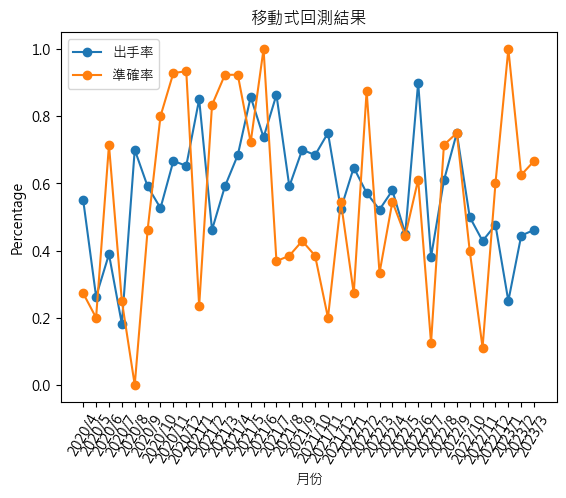

In [262]:
l1 = plt.plot(months, go_list, label="出手率")
plt.setp(l1, marker='o')
l2 = plt.plot(months, acc_list, label="準確率")
plt.setp(l2, marker='o')

xloc = np.arange(0, len(months), 3)
plt.xticks(rotation=60)
plt.title("移動式回測結果")
plt.xlabel("月份")
plt.ylabel("Percentage")
plt.legend(loc='best')

plt.show()